In [1]:
import os
import gc
import pickle

import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import mean_absolute_error
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import VotingRegressor
import numpy as np
import datetime
import lightgbm as lgb

import optuna
from feature_engineer import *

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
root = "../../dataset"
save_path = None
load_path = None

In [3]:
df_data        = pl.read_csv(os.path.join(root, "train.csv"), try_parse_dates=True)
df_client      = pl.read_csv(os.path.join(root, "client.csv"), try_parse_dates=True)
df_gas         = pl.read_csv(os.path.join(root, "gas_prices.csv"), try_parse_dates=True)
df_electricity = pl.read_csv(os.path.join(root, "electricity_prices.csv"), try_parse_dates=True)
df_forecast    = pl.read_csv(os.path.join(root, "forecast_weather.csv"), try_parse_dates=True)
df_historical  = pl.read_csv(os.path.join(root, "historical_weather.csv"), try_parse_dates=True)
df_location    = pl.read_csv(os.path.join(root, "weather_station_to_county_mapping.csv"), try_parse_dates=True)

In [4]:
name_to_location_map = {
    0: [59.37564599072755, 24.76634160396904],
    1: [58.933990104765385, 22.592611630193417],
    2: [59.260027110999104, 27.424623084957503],
    3: [58.93141428698745, 25.61492605120901],
    4: [58.75129581441412, 26.396217935199086],
    5: [59.351855094338006, 26.358582291361408],
    6: [58.971844103963996, 23.865264807862204],
    7: [58.529730512924466, 24.390625023202976],
    8: [58.115278626639046, 27.210355429168683],
    9: [59.001783512075306, 24.800546663034282],
    10: [58.40187275691764, 22.473957776666857],
    11: [58.38464096871995, 26.742185601931066],
    13: [57.910997459035016, 26.161956297267043],
    14: [58.362156921790586, 25.589748513576247],
    15: [57.84391746680313, 27.00999868536037],
}
country_names = []
separation = []
for lat, long in zip(df_location["latitude"],df_location["longitude"]):
    distances = {k:np.sqrt(((lat-v[0])**2)+((long-v[1])**2))*111 for k,v in name_to_location_map.items()}
    key = min(distances,key=lambda x: distances[x])
    if distances[key]<50:
        country_names.append(key)
        separation.append(distances[key])
    else:
        country_names.append(12)
        separation.append(50)   
df_location = df_location.with_columns(pl.Series(name="county", values=country_names))

# Feature Engineering

In [5]:
# immediate changes
df_data = df_data.with_columns(pl.col("datetime").dt.date().alias("date").cast(pl.Date))
df_forecast = df_forecast.with_columns(pl.col("forecast_datetime").alias("forecast_datetime").cast(pl.Datetime))
df_forecast = df_forecast.with_columns(pl.col("latitude").round(1).cast(str),pl.col("longitude").round(1).cast(str))
df_location = df_location.with_columns(pl.col("latitude").round(1).cast(str),pl.col("longitude").round(1).cast(str))

In [6]:
df_data = df_data.filter(pl.col("datetime")>=datetime.datetime(2021, 9, 2, 0, 0))
df_data = df_data.filter(pl.col("target")!=None)
df_data = add_electricity_prices(df_data,df_electricity)
df_data = add_gas_price(df_data,df_gas)
df_data =  add_client(df_data,df_client)
df_data = add_latest_weather(df_data,df_forecast,df_location)
df_data = extend_month_weekday(df_data)
df_data = df_data.sort(by="datetime")

### Training

In [7]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

In [8]:
class TimeFold:
    def __init__(self, train_range=28, test_range=14,mincount=5000):
        self.train_range = train_range
        self.test_range = test_range
        self.mincount=mincount
    def split(self, X):
        end = len(X) - 1
        while end >= 0:
            test_indices = np.where((X <= X[end]) & (X > (X[end] - datetime.timedelta(days=self.test_range))))[0]
            train_indices = np.where((X <= (X[end] - datetime.timedelta(days=self.test_range))) & (X > (X[end] - datetime.timedelta(days=self.train_range + self.test_range))))[0]
            end = train_indices[0] - 1 if len(train_indices) > 0 else -1
            if len(test_indices)>self.mincount and len(train_indices)>self.mincount:
                yield train_indices, test_indices

In [9]:
def get_metrics(gt,pred):
    return {
        "length": len(gt),
        "mae": mean_absolute_error(gt,pred),
        "rmse": np.sqrt(mean_squared_error(gt,pred)),
        "r2_score": r2_score(gt,pred),
    }

In [13]:
drop_cols=["target","datetime","row_id","data_block_id","prediction_unit_id","date"]
target_col = "target"
best_params = {
    'n_iter'           : 700,
    'verbose'          : 1,
    'objective'        : 'l2',
    'learning_rate'    : 0.05689066836106983,
    'colsample_bytree' : 0.8915976762048253,
    'colsample_bynode' : 0.5942203285139224,
    'lambda_l1'        : 3.6277555139102864,
    'lambda_l2'        : 1.6591278779517808,
    'min_data_in_leaf' : 186,
    'max_depth'        : 9,
    'max_bin'          : 813,
} 

folds = TimeFold(train_range=365,test_range=365)
train_res = []
test_res = []
for i,(train,test) in enumerate(folds.split(df_data["datetime"].to_pandas())):
    train = df_data[train]
    test = df_data[test]
    model = lgb.LGBMRegressor(**best_params, random_state=100) 
    model.fit(
        X=train.drop(drop_cols),
        y=train[target_col],
    )
    predictions = model.predict(test.drop(drop_cols))
    test_res.append([predictions,test[target_col].to_numpy()])
    test_met = get_metrics(test[target_col],predictions)
    predictions = model.predict(train.drop(drop_cols))
    train_res.append([predictions,train[target_col].to_numpy()])
    train_met = get_metrics(train[target_col],predictions)
    print(f"FOLD {i+1} || train_mae: {train_met} valid_mae: {test_met} ||")

test_met = get_metrics(np.concatenate([x[1] for x in test_res]),np.concatenate([x[0] for x in test_res]))
print(f"Overall || valid_mae: {test_met} ||")

/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:172: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] lambda_l2 is set=1.6591278779517808, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6591278779517808
[LightGBM] [Warning] num_iterations is set=700, n_iter=700 will be ignored. Current value: num_iterations=700
[LightGBM] [Warning] lambda_l1 is set=3.6277555139102864, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6277555139102864
[LightGBM] [Warning] min_data_in_leaf is set=186, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=186
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] min_data_in_leaf is set=186, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=186
[LightGBM] [Warning] lambda_l2 is set=1.6591278779517808, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6591278779517808
[LightGBM] [Warning] lambda_l1 is set=3.6277555139102864, reg_alpha=0.0 will be ignored. Current value: lambda_

Exception ignored on calling ctypes callback function: <function _log_callback at 0x7fdb0aafa550>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py", line 203, in _log_callback
    def _log_callback(msg: bytes) -> None:
KeyboardInterrupt: 


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leave

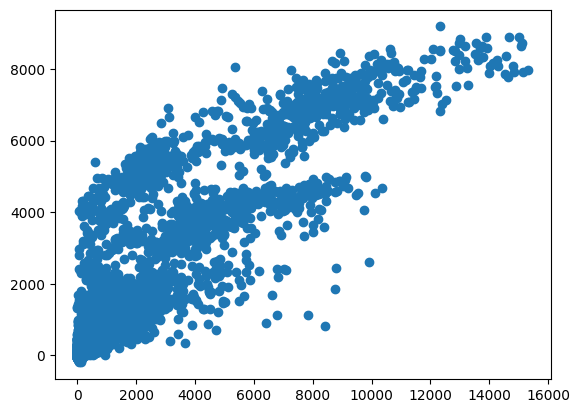

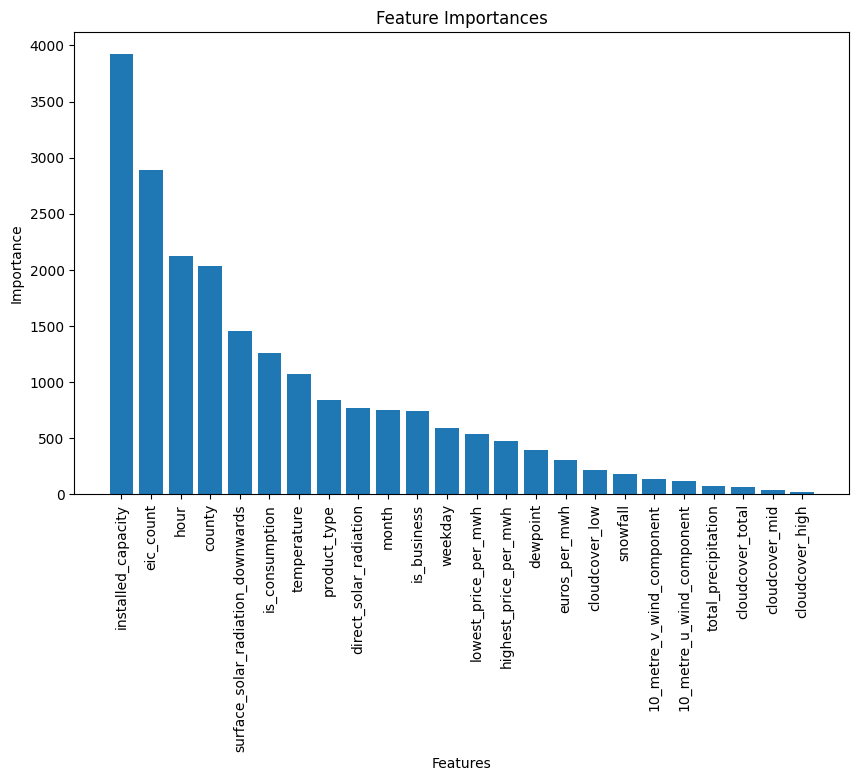

In [11]:
gts = np.concatenate([x[1] for x in test_res])
preds = np.concatenate([x[0] for x in test_res])
mask = np.random.rand(len(gts))<0.05
plt.scatter(gts[mask],preds[mask])
plt.show()
# Get feature importances
feature_importances = model.feature_importances_
argsort = np.argsort(model.feature_importances_)[::-1]
feature_importances = [feature_importances[x] for x in argsort]
columns = test.drop(drop_cols).columns
# Plotting the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.xticks(ticks=np.arange(len(feature_importances)), labels=[columns[x] for x in argsort],rotation=90)
plt.show()

In [27]:
if save_path is not None:
    with open(save_path, "wb") as f:
        pickle.dump(model, f)

### Prediction

In [ ]:
import enefit

env = enefit.make_env()
iter_test = env.iter_test()

In [ ]:
for (test, revealed_targets, client, historical_weather,
        forecast_weather, electricity_prices, gas_prices, sample_prediction) in iter_test:
    
    test = test.rename(columns={"prediction_datetime": "datetime"})
    
    df_test           = pl.from_pandas(test[data_cols[1:]], schema_overrides=schema_data)
    df_client         = pl.from_pandas(client[client_cols], schema_overrides=schema_client)
    df_gas            = pl.from_pandas(gas_prices[gas_cols], schema_overrides=schema_gas)
    df_electricity    = pl.from_pandas(electricity_prices[electricity_cols], schema_overrides=schema_electricity)
    df_new_forecast   = pl.from_pandas(forecast_weather[forecast_cols], schema_overrides=schema_forecast)
    df_new_historical = pl.from_pandas(historical_weather[historical_cols], schema_overrides=schema_historical)
    df_new_target     = pl.from_pandas(revealed_targets[target_cols], schema_overrides=schema_target)
    
    df_forecast       = pl.concat([df_forecast, df_new_forecast]).unique()
    df_historical     = pl.concat([df_historical, df_new_historical]).unique()
    df_target         = pl.concat([df_target, df_new_target]).unique()
    
    X_test = feature_eng(df_test, df_client, df_gas, df_electricity, df_forecast, df_historical, df_location, df_target)
    X_test = to_pandas(X_test)
    
    test['target'] = model.predict(X_test).clip(0)
    test['target_solar'] = model_solar.predict(X_test).clip(0)
    test.loc[test['is_consumption']==0, "target"] = test.loc[test['is_consumption']==0, "target_solar"]    
    
    sample_prediction["target"] = test['target']
    
    env.predict(sample_prediction)

# Hyperparameter Optimization

In [ ]:
best_params = {
    'n_iter'           : 700,
    'verbose'          : -1,
    'objective'        : 'l2',
    'learning_rate'    : 0.05689066836106983,
    'colsample_bytree' : 0.8915976762048253,
    'colsample_bynode' : 0.5942203285139224,
    'lambda_l1'        : 3.6277555139102864,
    'lambda_l2'        : 1.6591278779517808,
    'min_data_in_leaf' : 186,
    'max_depth'        : 9,
    'max_bin'          : 813,
} # val score is 62.24 for the last month

best_params_solar = {
    'n_iter'           : 500,
    'verbose'          : -1,
    'objective'        : 'l2',
    'learning_rate'    : 0.05689066836106983,
    'colsample_bytree' : 0.8915976762048253,
    'colsample_bynode' : 0.5942203285139224,
    'lambda_l1'        : 3.6277555139102864,
    'lambda_l2'        : 1.6591278779517808,
    'min_data_in_leaf' : 186,
    'max_depth'        : 9,
    'max_bin'          : 813,
} # val score is 62.24 for the last month
# study = optuna.create_study(direction='minimize', study_name='Regressor')
# study.optimize(lgb_objective, n_trials=100, show_progress_bar=True)